In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

<Axes: xlabel='Month'>

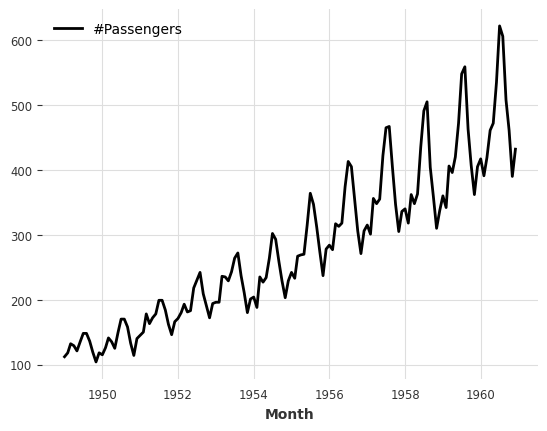

In [2]:
# plot TS
series = AirPassengersDataset().load()
series.plot()

<Axes: xlabel='Month'>

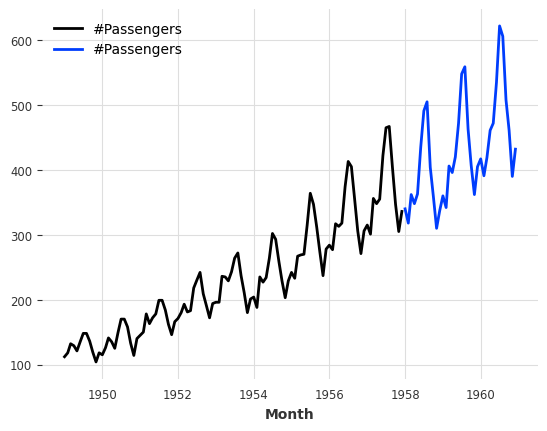

In [3]:
# splitting
series1, series2 = series.split_after(0.75)
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

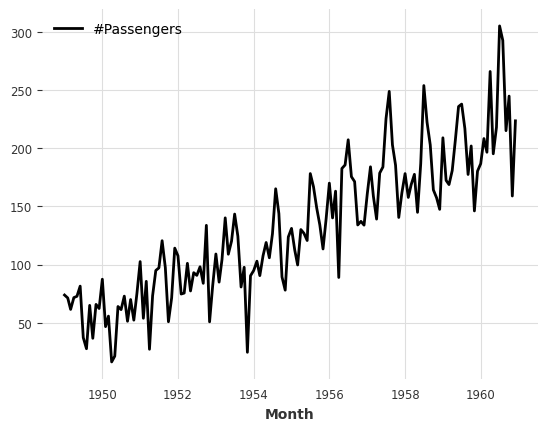

In [4]:
# adding noise
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()

<Axes: xlabel='Month'>

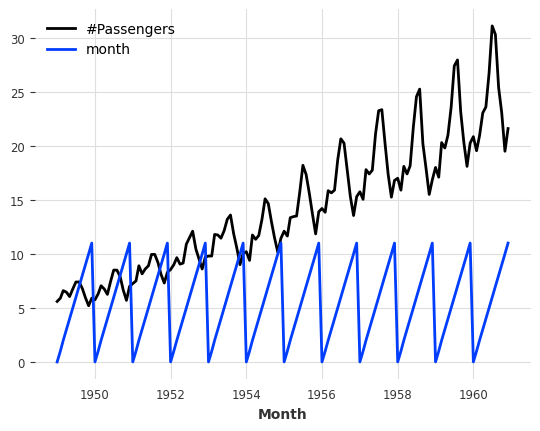

In [5]:
# adding attributes
(series / 20).add_datetime_attribute("month").plot()

<Axes: xlabel='Month'>

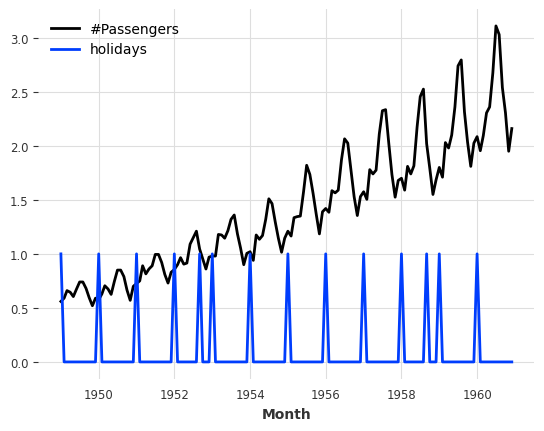

In [6]:
# holidays
(series / 200).add_holidays("US").plot()

# Prediction with DARTS

<Axes: xlabel='Month'>

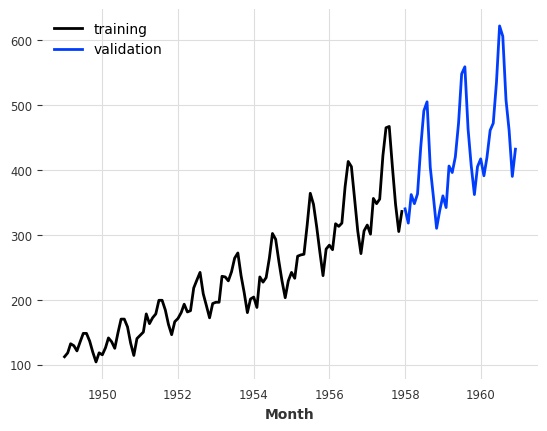

In [7]:
# creating train and test sets
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

<Axes: xlabel='Month'>

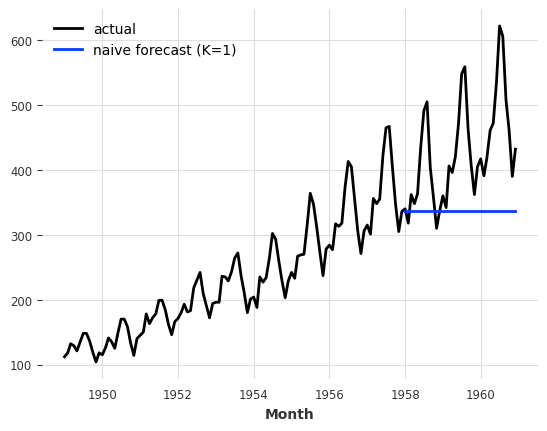

In [8]:
# naive forecast
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

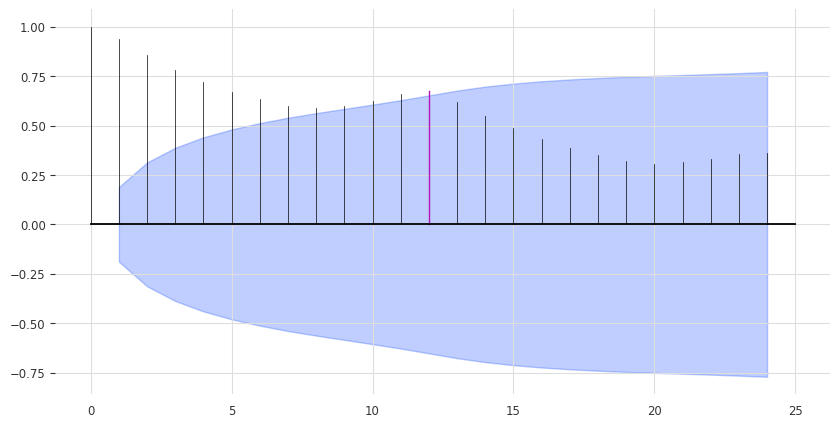

In [9]:
# seasonality
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05)

In [10]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


<Axes: xlabel='Month'>

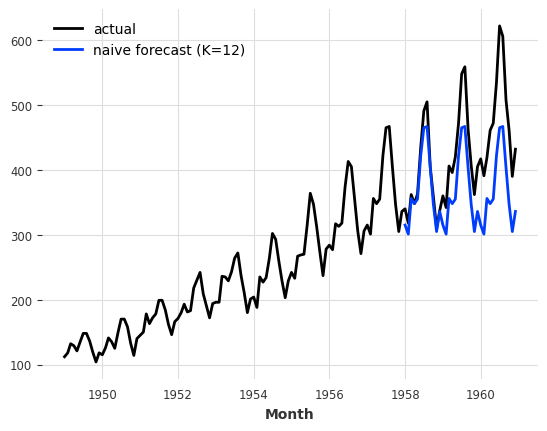

In [11]:
# less naive model
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

<Axes: xlabel='Month'>

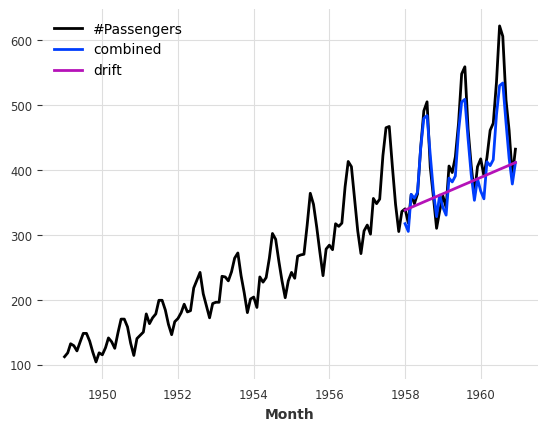

In [12]:
# naive drift
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

In [13]:
# error metrics
from darts.metrics import mape

print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [14]:
# quick eval of several models
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
# eval_model(TBATS())
# eval_model(AutoARIMA())
# eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%


In [15]:
# evaluate naive drift + seasonal model
class NaiveDriftSeasonal():

    def __init__(self):
        self.drift_model = NaiveDrift()
        self.seasonal_model = NaiveSeasonal(K=12)

    def fit(self, series):
        self.drift_model.fit(series)
        self.seasonal_model.fit(series)
        pass

    def predict(self, n):
        drift_forecast = drift_model.predict(36)
        seasonal_forecast = seasonal_model.predict(36)

        combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
        return combined_forecast

    def __str__(self):
        return "NaiveDriftSeasonal"

In [16]:
eval_model(NaiveDriftSeasonal())

model NaiveDriftSeasonal obtains MAPE: 5.66%


In [17]:
eval_model(Theta())

model Theta() obtains MAPE: 8.15%


In [18]:
# hyperparameter tuning for Theta
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

In [19]:
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 4.40, with theta = -3.5102040816326543.


<Axes: xlabel='Month'>

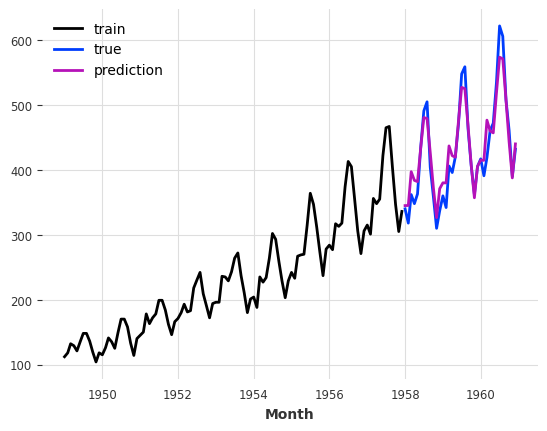

In [20]:
# show results
train.plot(label="train")
val.plot(label="true")
pred_best_theta.plot(label="prediction")

In [21]:
# NBEATS
from darts.models import NBEATSModel
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)
model.fit(train, epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

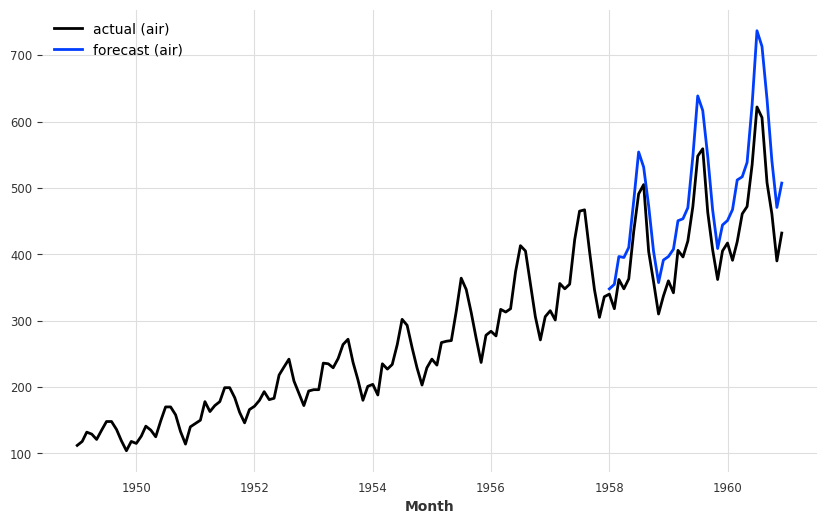

In [22]:
pred = model.predict(series=train, n=36)

plt.figure(figsize=(10, 6))
series.plot(label="actual (air)")
pred.plot(label="forecast (air)")

<Axes: xlabel='Month'>

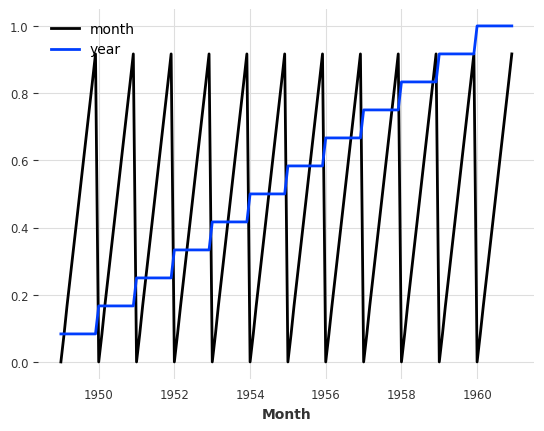

In [23]:
# multivariate
from darts import concatenate
from darts.utils.timeseries_generation import datetime_attribute_timeseries as dt_attr

air_covs = concatenate(
    [
        dt_attr(series.time_index, "month", dtype=np.float32) / 12,
        (dt_attr(series.time_index, "year", dtype=np.float32) - 1948) / 12,
    ],
    axis="component",
)

air_covs.plot()

In [24]:
# fit multivariate
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit(
    train,
    past_covariates=air_covs,
    epochs=50,
    verbose=True,
);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.6 M 
---------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

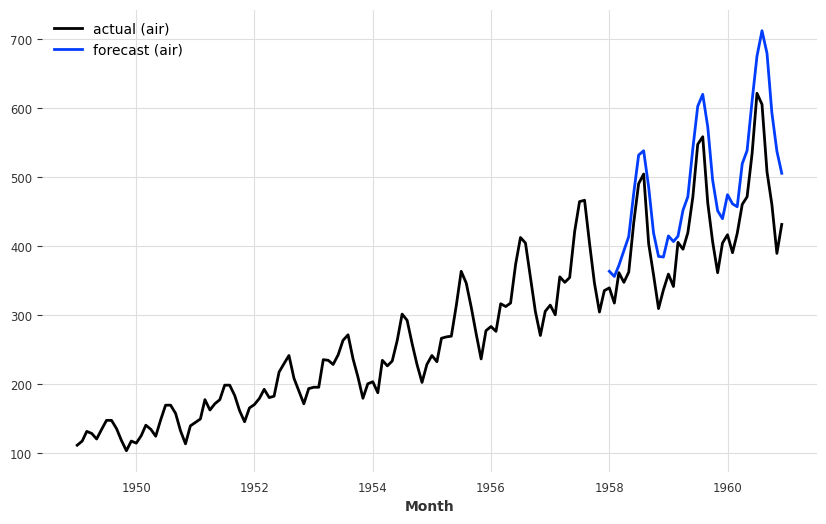

In [25]:
# depict
pred = model.predict(series=train, n=36)

plt.figure(figsize=(10, 6))
series.plot(label="actual (air)")
pred.plot(label="forecast (air)")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

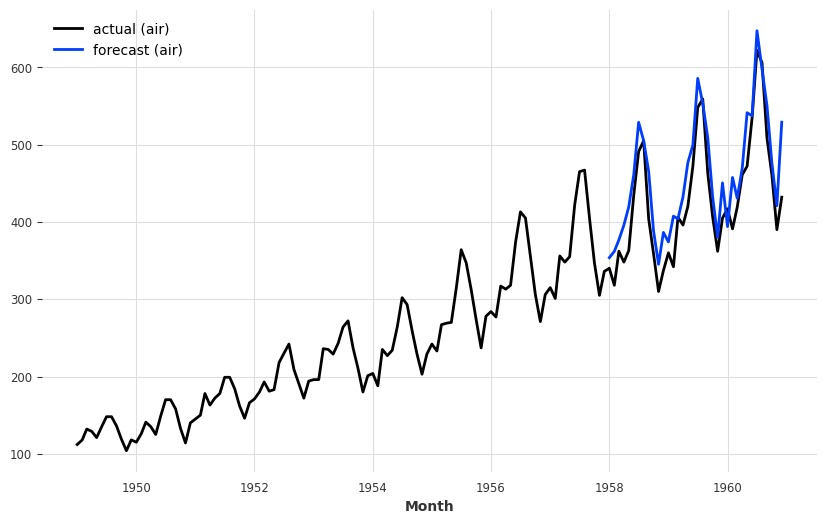

In [26]:
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()

# scaling with encoders
encoders = {"datetime_attribute": {"past": ["month", "year"]}, "transformer": Scaler()}

model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
)

train_air_scaled = scaler.fit_transform(train)

model.fit(train_air_scaled, epochs=50, verbose=True)

pred_air = model.predict(series=train_air_scaled, n=36)

# scale back:
pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

In [27]:
mape(series, pred_air)

8.241512422238111

## Regression forecasting
RegressionModel’s are forecasting models which wrap around sklearn-compatible regression models. The inner regression model is used to predict future values of the target series, as a function of certain lags of the target, past and future covariates. Behind the scenes, the time series are tabularized in order to build a training dataset in the right format.

By default, the RegressionModel will do a linear regression. It is very easy to use any desired sklearn-compatible regression model by specifying the model parameter, but for convenience Darts also provides a couple of ready-made models out of the box:

RandomForest wraps around sklearn.ensemble.RandomForestRegressor.

LightGBMModel wraps around lightbm.

LinearRegressionModel wraps around sklearn.linear_model.LinearRegression (accepting the same kwargs).

In [28]:
from darts.models import RegressionModel
from sklearn.linear_model import BayesianRidge

model = RegressionModel(lags=72, lags_future_covariates=[-6, 0], model=BayesianRidge())

model.fit(
    train_air_scaled, future_covariates=air_covs
);

<Axes: xlabel='Month'>

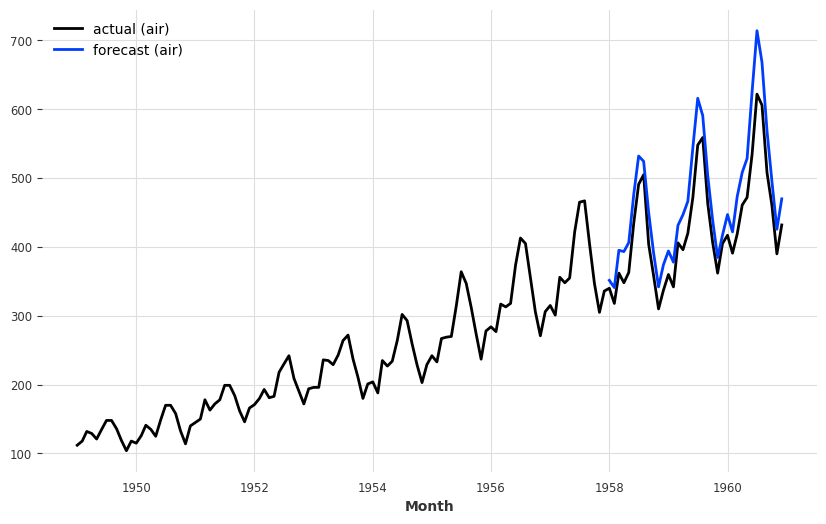

In [29]:
pred_air = model.predict(
    series=train_air_scaled,
    future_covariates=air_covs,
    n=36,
)

# scale back:
pred_air = scaler.inverse_transform(pred_air)

plt.figure(figsize=(10, 6))
series.plot(label="actual (air)")
pred_air.plot(label="forecast (air)")

In [30]:
mape(series, pred_air)

9.666434692573162

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 3.66


<Axes: xlabel='time'>

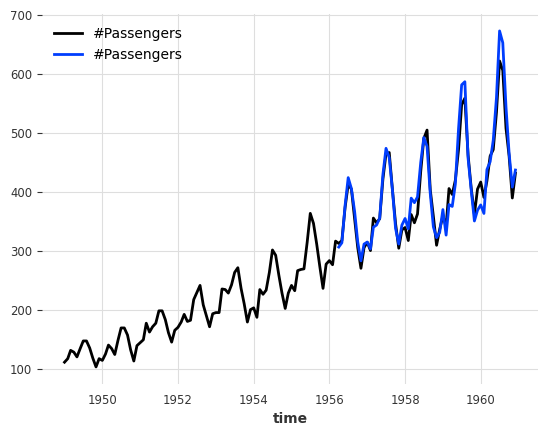

In [32]:
bayes_ridge_model = RegressionModel(
    lags=72, lags_future_covariates=[0], model=BayesianRidge()
)

backtest = bayes_ridge_model.historical_forecasts(
    series, future_covariates=air_covs, start=0.6, forecast_horizon=3, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series)))
series.plot()
backtest.plot()

## Probabilistic forecasts

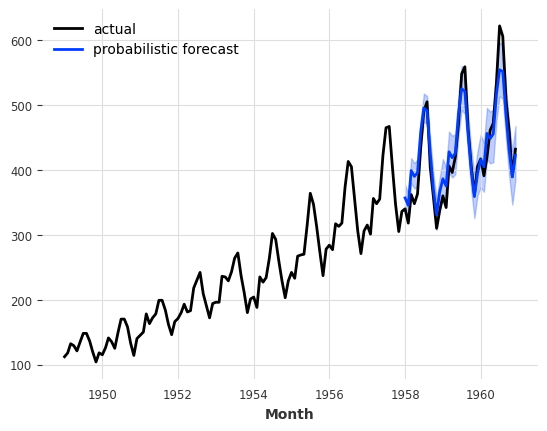

In [33]:
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

In [34]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
----------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

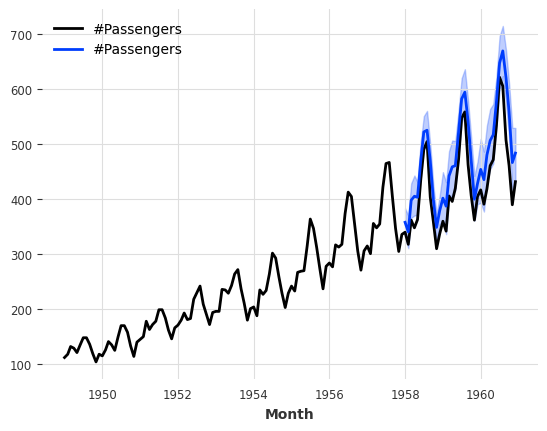

In [35]:
pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series.plot()
pred.plot()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 166   
----------------------------------------------------
166       Trainable params
0         Non-trainable params
166       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

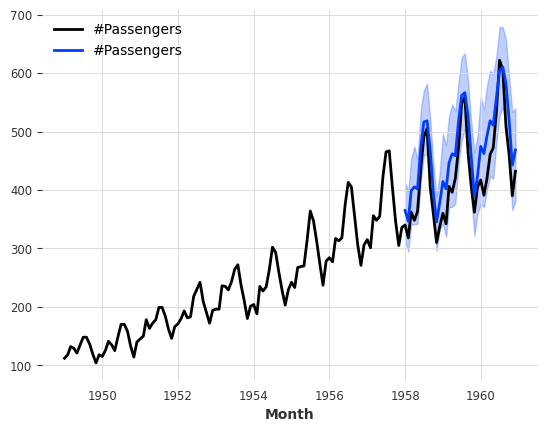

In [36]:
model = TCNModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    likelihood=LaplaceLikelihood(prior_b=0.1),
)

model.fit(train_air_scaled, epochs=400, verbose=True);

pred = model.predict(n=36, num_samples=500)

# scale back:
pred = scaler.inverse_transform(pred)

series.plot()
pred.plot()

<Axes: xlabel='Month'>

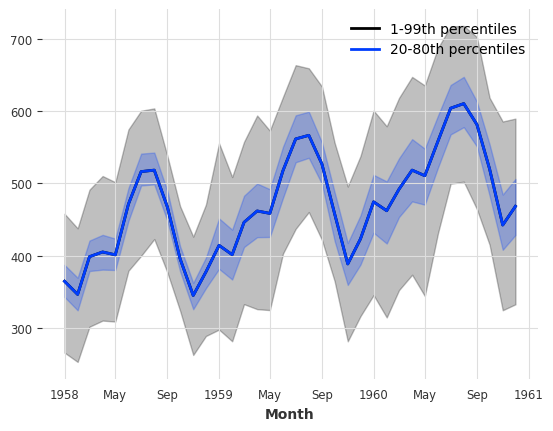

In [37]:
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

## Ensembes

  0%|          | 0/57 [00:00<?, ?it/s]

MAPE = 4.81


<Axes: xlabel='time'>

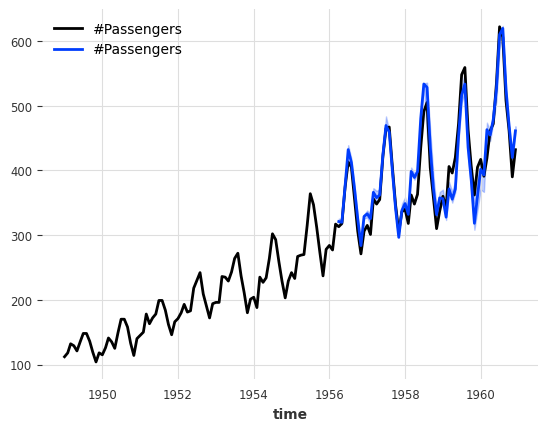

In [40]:
from darts.models import RegressionEnsembleModel
from darts.models import LinearRegressionModel

quantiles = [0.25, 0.5, 0.75]

models = [NaiveDrift(), NaiveSeasonal(12)]

regression_model = LinearRegressionModel(
    quantiles=quantiles,
    lags_future_covariates=[0],
    likelihood="quantile",
    fit_intercept=False,
)

ensemble_model = RegressionEnsembleModel(
    forecasting_models=models,
    regression_train_n_points=12,
    regression_model=regression_model,
)

backtest = ensemble_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, num_samples=500, verbose=True
)

print("MAPE = %.2f" % (mape(backtest, series)))
series.plot()
backtest.plot()

## Filtering models

<Axes: xlabel='Month'>

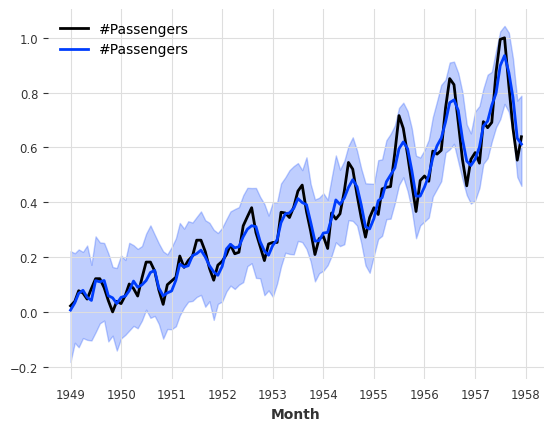

In [41]:
from darts.models import KalmanFilter

kf = KalmanFilter(dim_x=3)
kf.fit(train_air_scaled)
filtered_series = kf.filter(train_air_scaled, num_samples=100)

train_air_scaled.plot()
filtered_series.plot()

## Other methods

### N-HiTS

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 10.3 M
---------------------------------------------------
10.2 M    Trainable params
18.5 K    Non-trainable params
10.3 M    Total params
41.021    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

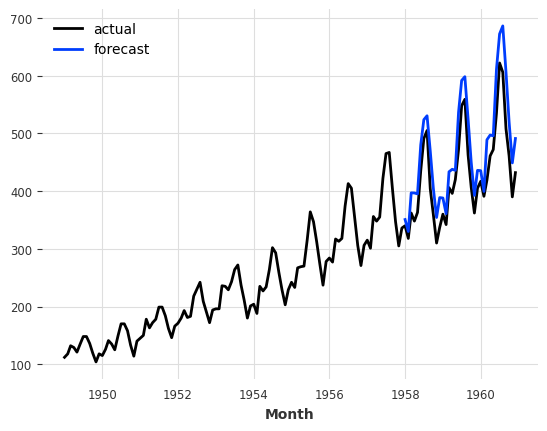

In [49]:
from darts.models import NHiTSModel
model = NHiTSModel(
    input_chunk_length=36,
    output_chunk_length=12,
    num_blocks=12,
    n_epochs=30,
)
model.fit(train)
pred = model.predict(36)

series.plot(label="actual")
pred.plot(label="forecast")

### N-Linear
(Transformer)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 156   
---------------------------------------------------
156       Trainable params
0         Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

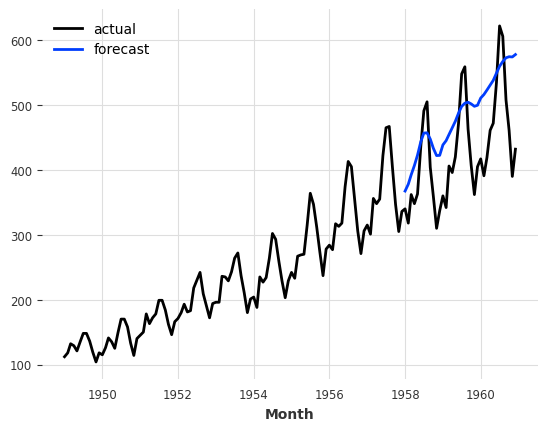

In [61]:
from darts.models import NLinearModel
model = NLinearModel(
    input_chunk_length=12,
    output_chunk_length=1,
    n_epochs=100,
)
model.fit(train)
pred = model.predict(36)

series.plot(label="actual")
pred.plot(label="forecast")

<Axes: xlabel='Month'>

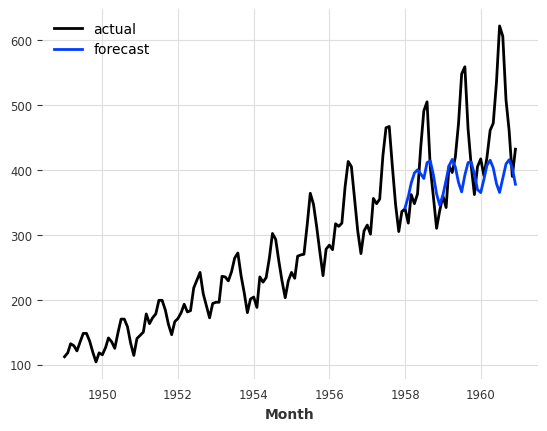

In [58]:
# RF
from darts.models import RandomForest

model = RandomForest(
    lags=12,
    output_chunk_length=6,
    n_estimators=200,
    criterion="absolute_error",
)

model.fit(train)
pred = model.predict(36)

series.plot(label="actual")
pred.plot(label="forecast")



In [60]:
# PatchTFT?
from darts.models import TFTModel

def encode_year(idx):
    return (idx.year - 1950) / 50

add_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [encode_year]},
    'tz': 'CET'
}

model = TFTModel(
    input_chunk_length=6,
    output_chunk_length=6,
    encoders=add_encoders,
    n_epochs=5,
)

model.fit(train)
pred = model.predict(36)

series.plot(label="actual")
pred.plot(label="forecast")

ValueError: Invalid model creation parameters. Model `TFTModel` has no args/kwargs `['encoders']`


ValueError: Invalid model creation parameters. Model `TFTModel` has no args/kwargs `['encoders']`